In [20]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import nltk 
from nltk.corpus import gutenberg
nltk.download('gutenberg')
nltk.download('punkt')
import os
import re
from spellchecker import SpellChecker
import matplotlib.pyplot as plt

[nltk_data] Downloading package gutenberg to
[nltk_data]     /home/infres/pmauduit-21/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/infres/pmauduit-21/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
device = torch.device('cuda:2'if torch.cuda.is_available() else "cpu") # Use GPU if available
print('device:', device)
print('current directory:', os.getcwd())

device: cuda:2
current directory: /home/infres/pmauduit-21/repository/DD2424-DL-Text_Gen_Project


### Import Data

In [4]:
alice = gutenberg.raw('carroll-alice.txt')
header = alice.find("CHAPTER I.")
alice = alice[header:]
# raw_text = alice.lower()
raw_text = alice
chars = sorted(list(set(raw_text)))
char_to_int = {c: i for i, c in enumerate(chars)}
int_to_char = {i: c for i, c in enumerate(chars)}
n_vocab = len(chars)
train_text = raw_text[:-22067]
val_text = raw_text[-22067:-11681]
test_text = raw_text[-11681:]

print('vocab size:', n_vocab)

vocab size: 69


### Generating text

In [5]:
class CharModel(nn.Module):
    def __init__(self, n_vocab, embedding_dim=128, hidden_size=256, num_layers=2, dropout=0, norm=False, type = 'lstm'):
        super().__init__()
        if embedding_dim > 1:
            self.embedding = nn.Embedding(num_embeddings=n_vocab, embedding_dim=embedding_dim)   
        if type == 'lstm':
            self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        elif type == 'gru':
            self.lstm = nn.GRU(input_size=embedding_dim, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        elif type == 'rnn':
            self.lstm = nn.RNN(input_size=embedding_dim, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        if norm:
            self.norm = nn.LayerNorm(hidden_size)
        self.linear = nn.Linear(hidden_size, n_vocab)

    def forward(self, x):
        # Convert input to Long type
        if hasattr(self, 'embedding'):
            x = x.long().squeeze(-1)
            x = self.embedding(x)
        else:
            x = x/float(n_vocab)
            if x.dim() == 2:
                x.unsqueeze_(-1) # Problem ???
        x, _ = self.lstm(x)
        # Take only the last output
        if x.dim() == 2:
            x = x.unsqueeze(0) # Problem with batch size = 1 during inference
        x = x[:, -1, :]
        # Normalize
        if hasattr(self, 'norm'):
            x = self.norm(x)
        x = self.linear(self.dropout(x))
        return x
    

In [6]:
# model = CharModel(n_vocab, embedding_dim=100, hidden_size=256, num_layers=2, dropout=0.3, norm=True, type='lstm').to(device)
# seq_length = 100
# best_model = torch.load("lstm_norm_True_raw.pt")

In [47]:
def apply_temperature_scaling(logits, temperature):
    logits = logits / temperature
    probs = torch.softmax(logits, dim=-1)
    return probs

def nucleus_sampling(probs, p, device):
    sorted_probs, sorted_indices = torch.sort(probs, descending=True)
    cumulative_probs = torch.cumsum(sorted_probs, dim=-1)    
    cutoff_index = torch.searchsorted(cumulative_probs, torch.tensor(p, device=device)).item() + 1
    top_probs = sorted_probs[:cutoff_index]
    top_indices = sorted_indices[:cutoff_index]    
    top_probs = top_probs / torch.sum(top_probs)    
    sampled_index = torch.multinomial(top_probs, 1).item()    
    return top_indices[sampled_index].item()

def generate_from_text(temperature=None, p = None, prompt=None, doPrint = False):
    if prompt is None:
        start = np.random.randint(0, len(raw_text)-seq_length)
        text_prompt = raw_text[start:start+seq_length]
        pattern = [char_to_int[c] for c in text_prompt]
        if doPrint:
            print('Prompt: "%s"' % text_prompt)
            print('-'*100)
    else:
        pattern = [char_to_int[c] for c in prompt]
        if doPrint:
            print('Prompt: "%s"' % prompt)
            print('-'*100)
    model.eval()
    generated_text = ""
    if prompt is not None:
        if doPrint:
            print(prompt, end="")
        generated_text += prompt
    with torch.no_grad():
        for i in range(1000):
            x = np.reshape(pattern, (1, len(pattern)))
            # x = torch.tensor(x, dtype=torch.float32)
            x = torch.tensor(x, dtype=torch.long)
            logits = model(x.to(device))
            if temperature is not None:
                scaled_probs = apply_temperature_scaling(logits, temperature)
                if p is not None:                
                    scaled_probs = scaled_probs.squeeze()
                    index = nucleus_sampling(scaled_probs, p, device)
                else:
                    index = torch.multinomial(scaled_probs, 1).item()
            else:
                index = int(logits.argmax())
            result = int_to_char[index]
            generated_text += result
            if doPrint:
                print(result, end="")
            pattern.append(index)
            if len(pattern) > seq_length:
                pattern = pattern[1:]
    if doPrint:
        print()
    print("Done.")    
    return generated_text

## Metrics methods

#### TTR score (Type Token Ratio: measure of vocabulary variation)

The higher the TTR score, the more diverse the vocabulary used in the text.

Temperature sampling gives higher TTR scores than nucleus sampling, but text is less coherent.

In [8]:
def calculate_ttr(text):
    words = text.split()
    unique_words = set(words)
    ttr = len(unique_words) / len(words)
    return ttr

#### Perplexity (how well the model predicts a word sequence)

The lower the perplexity, the better the model predicts the next word.

Greedy sampling gives the lowest perplexity, but text is also the least diverse.

In [9]:
def calculate_perplexity(text, model, tokenizer, device):
    encodings = tokenizer(text, return_tensors='pt')
    max_length = model.config.n_positions
    stride = 512

    lls = []
    for i in range(0, encodings.input_ids.size(1), stride):
        begin_loc = max(i + stride - max_length, 0)
        end_loc = min(i + stride, encodings.input_ids.size(1))
        trg_len = end_loc - i
        input_ids = encodings.input_ids[:, begin_loc:end_loc].to(device)
        target_ids = input_ids.clone().to(device)
        target_ids[:, :-trg_len] = -100

        with torch.no_grad():
            outputs = model(input_ids, labels=target_ids)
            log_likelihood = outputs.loss * trg_len

        lls.append(log_likelihood)

    ppl = torch.exp(torch.stack(lls).sum() / end_loc)
    return ppl.item()

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
gpt2_model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)

#### Spell Check

We clean the text by removing special characters. 

In [10]:
def calculate_correctly_spelled_percentage(text):
    # Initialize the spell checker
    spell = SpellChecker()

    # Remove punctuation and split the text into words
    words = re.findall(r'\b\w+\b', text)

    # Check each word for correctness
    misspelled = spell.unknown(words)

    # Calculate the number of correctly spelled words
    correctly_spelled_count = len(words) - len(misspelled)

    # Calculate the percentage of correctly spelled words
    if len(words) == 0:
        return 0.0  # Avoid division by zero if there are no words
    correctly_spelled_percentage = (correctly_spelled_count / len(words)) * 100

    return correctly_spelled_percentage



#### BLEU score

In [11]:
def calculate_bleu_score(reference_text, generated_text):
    # Tokenize the reference and generated text
    reference_tokens = nltk.word_tokenize(reference_text)
    generated_tokens = nltk.word_tokenize(generated_text)

    # Reference text should be a list of lists of tokens
    reference_list = [reference_tokens]

    # Use SmoothingFunction to handle very short texts
    smoothing_function = SmoothingFunction().method4

    # Compute BLEU score
    bleu_score = sentence_bleu(reference_list, generated_tokens, smoothing_function=smoothing_function)

    return bleu_score

# Evaluation

## Comparing sampling methods

In [126]:
model = CharModel(n_vocab, embedding_dim=100, hidden_size=512, num_layers=2, dropout=0.3, norm=True, type='lstm').to(device)
seq_length = 200
best_model = torch.load("LSTM_biggest_model/lstm_norm_True_raw_huge.pt")

n_vocab = len(char_to_int)
int_to_char = dict((i, c) for c, i in char_to_int.items())
model.load_state_dict(best_model)

model.eval()

reference_text = alice

# torch.manual_seed(5)
# np.random.seed(5)

greedy_text = generate_from_text(temperature=None, p=None, prompt='A', doPrint=False)
temperature_text = generate_from_text(temperature=0.7, p=None, prompt='A', doPrint=False)
nucleus_text = generate_from_text(temperature=0.7, p=0.8, prompt='A', doPrint=False)

Done.
Done.
Done.


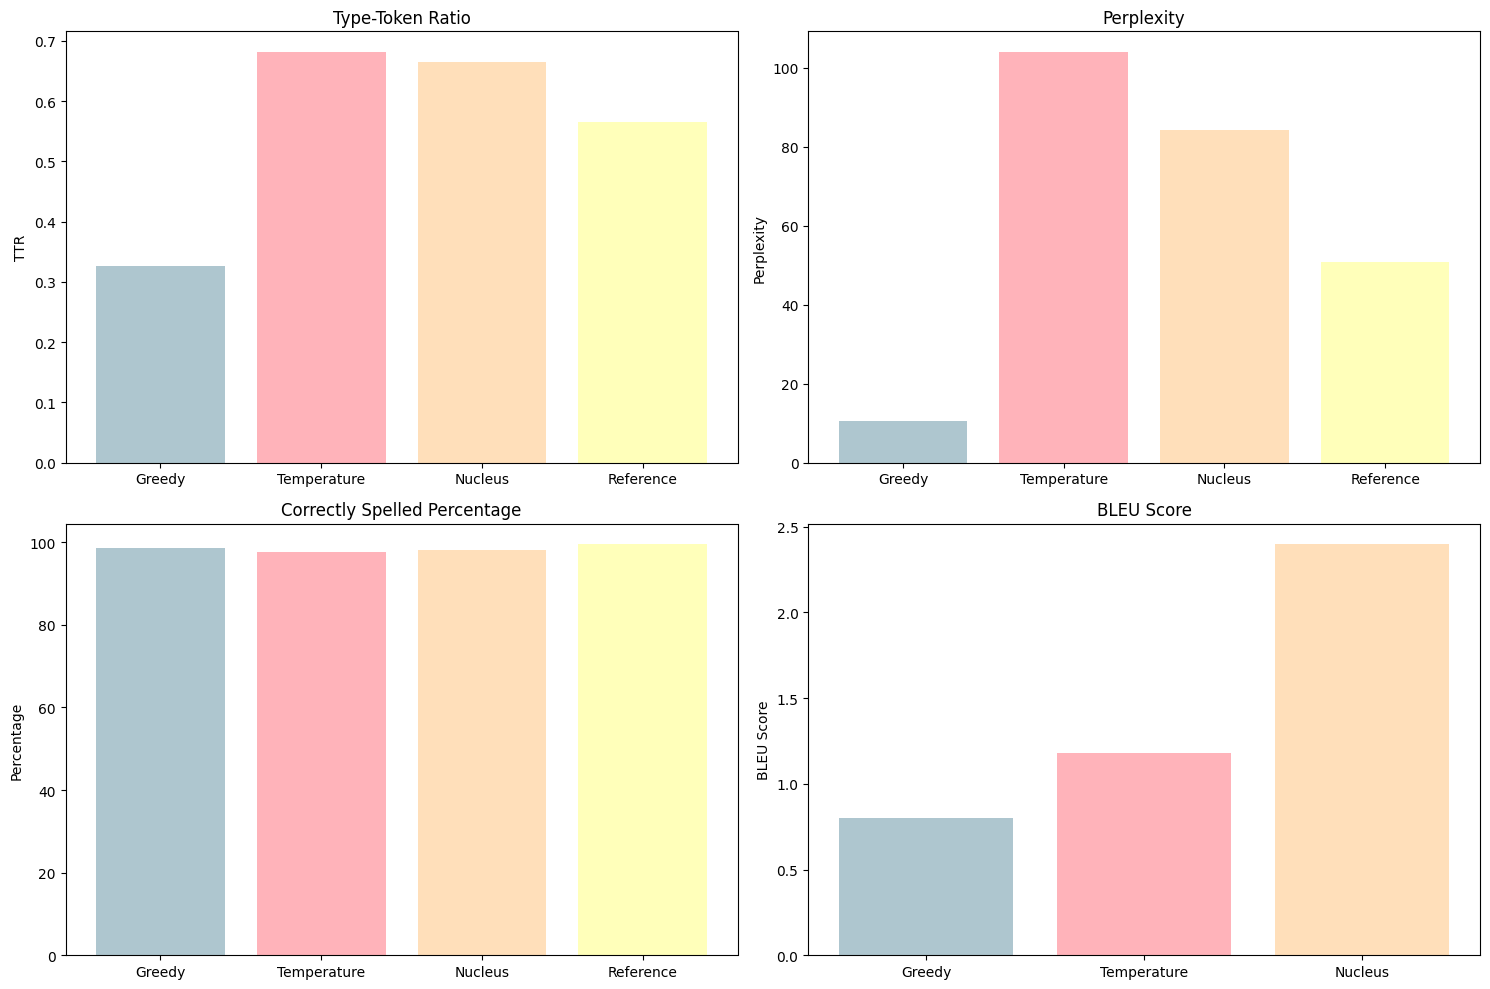

In [133]:
reference_text = alice[-1000:]

ttr_scores = [calculate_ttr(greedy_text), calculate_ttr(temperature_text), calculate_ttr(nucleus_text), calculate_ttr(reference_text)]
perplexity_scores = [calculate_perplexity(greedy_text, gpt2_model, tokenizer, device), calculate_perplexity(temperature_text, gpt2_model, tokenizer, device), 
                     calculate_perplexity(nucleus_text, gpt2_model, tokenizer, device), calculate_perplexity(reference_text, gpt2_model, tokenizer, device)]
correctly_spelled_percentages = [calculate_correctly_spelled_percentage(greedy_text), calculate_correctly_spelled_percentage(temperature_text), 
                                 calculate_correctly_spelled_percentage(nucleus_text), calculate_correctly_spelled_percentage(reference_text)]
bleu_scores = [calculate_bleu_score(reference_text, greedy_text), calculate_bleu_score(reference_text, temperature_text), 
               calculate_bleu_score(reference_text, nucleus_text), 100.0] 
bleu_scores = [bleu * 100 for bleu in bleu_scores]

methods = ['Greedy', 'Temperature', 'Nucleus', 'Reference']
pastel_colors = ['#aec6cf', '#ffb3ba', '#ffdfba', '#ffffba']

fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax[0, 0].bar(methods, ttr_scores, color=pastel_colors)
ax[0, 0].set_title('Type-Token Ratio')
ax[0, 0].set_ylabel('TTR')
ax[0, 1].bar(methods, perplexity_scores, color=pastel_colors)
ax[0, 1].set_title('Perplexity')
ax[0, 1].set_ylabel('Perplexity')
ax[1, 0].bar(methods, correctly_spelled_percentages, color=pastel_colors)
ax[1, 0].set_title('Correctly Spelled Percentage')
ax[1, 0].set_ylabel('Percentage')
ax[1, 1].bar(methods[:3], bleu_scores[:3], color=pastel_colors)
ax[1, 1].set_title('BLEU Score')
ax[1, 1].set_ylabel('BLEU Score')
plt.tight_layout()
plt.show()

### TTR

In [13]:
greedy_ttr = calculate_ttr(greedy_text)
temperature_ttr = calculate_ttr(temperature_text)
nucleus_ttr = calculate_ttr(nucleus_text)

print("Greedy TTR:", greedy_ttr)
print("Temperature TTR:", temperature_ttr)
print("Nucleus TTR:", nucleus_ttr)

Greedy TTR: 0.32663316582914576
Temperature TTR: 0.643979057591623
Nucleus TTR: 0.6649484536082474


### Perplexity

In [14]:
reference_text = raw_text[-1000:]

perplexity_greedy = calculate_perplexity(greedy_text, gpt2_model, tokenizer, device)
print(f"Perplexity greedy: {perplexity_greedy}")

perplexity_temperature = calculate_perplexity(temperature_text, gpt2_model, tokenizer, device)
print(f"Perplexity temperature: {perplexity_temperature}")

perplexity_nucleus = calculate_perplexity(nucleus_text, gpt2_model, tokenizer, device)
print(f"Perplexity nucleus: {perplexity_nucleus}")

perplexity = calculate_perplexity(reference_text, gpt2_model, tokenizer, device)
print(f"Perplexity reference: {perplexity}")

Perplexity greedy: 10.627132415771484
Perplexity temperature: 63.763771057128906
Perplexity nucleus: 94.1368179321289
Perplexity reference: 50.75355911254883


### Spell Check

In [15]:
greedy_text_percentage = calculate_correctly_spelled_percentage(greedy_text)
print(f"Greedy Text Percentage of correctly spelled words: {greedy_text_percentage:.2f}%")

temperature_text_percentage = calculate_correctly_spelled_percentage(temperature_text)
print(f"Temperature Text Percentage of correctly spelled words: {temperature_text_percentage:.2f}%")

nucleus_text_percentage = calculate_correctly_spelled_percentage(nucleus_text)
print(f"Nucleus Text Percentage of correctly spelled words: {nucleus_text_percentage:.2f}%")

reference_text_percentage = calculate_correctly_spelled_percentage(reference_text)
print(f"Reference Text Percentage of correctly spelled words: {reference_text_percentage:.2f}%")


Greedy Text Percentage of correctly spelled words: 98.55%


Temperature Text Percentage of correctly spelled words: 95.98%
Nucleus Text Percentage of correctly spelled words: 96.53%
Reference Text Percentage of correctly spelled words: 99.46%


### BLEU Score

In [16]:
reference_text = alice[-1000:]
greedy_bleu_score = calculate_bleu_score(reference_text, greedy_text) * 100
print(f"Greedy BLEU Score: {greedy_bleu_score:.2f}")

temperature_bleu_score = calculate_bleu_score(reference_text, temperature_text) * 100
print(f"Temperature BLEU Score: {temperature_bleu_score:.2f}")

nucleus_bleu_score = calculate_bleu_score(reference_text, nucleus_text) * 100
print(f"Nucleus BLEU Score: {nucleus_bleu_score:.2f}")


Greedy BLEU Score: 0.80
Temperature BLEU Score: 1.51
Nucleus BLEU Score: 2.99


## Hidden Size Comparison

In [17]:
hidden_sizes = [64, 128, 256, 512]
seq_length = 100
texts = []

for h in hidden_sizes:
    model = CharModel(n_vocab, embedding_dim=50, hidden_size=h, num_layers=2, dropout=0, norm=False, type='lstm').to(device)
    best_model = torch.load(f"LSTM_Hidden_Size/lstm_layers_2_hidden_{h}.pt")
    n_vocab = len(char_to_int)
    int_to_char = dict((i, c) for c, i in char_to_int.items())
    model.load_state_dict(best_model)
    model.eval()
    nucleus_text = generate_from_text(temperature=0.8, p=0.9, prompt='A', doPrint=False)
    texts.append(nucleus_text)

ttr_scores = []
perplexity_scores = []
text_percentage_scores = []
bleu_scores = []

for k in range(len(hidden_sizes)):
    ttr_score = calculate_ttr(texts[k])
    ttr_scores.append(ttr_score)
    perplexity_score = calculate_perplexity(texts[k], gpt2_model, tokenizer, device)
    perplexity_scores.append(perplexity_score)
    text_percentage = calculate_correctly_spelled_percentage(texts[k])
    text_percentage_scores.append(text_percentage)
    bleu_score = calculate_bleu_score(reference_text, texts[k]) * 100
    bleu_scores.append(bleu_score)
    
indices = np.arange(len(hidden_sizes))
f = plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.bar(indices, ttr_scores, width=0.5, color=pastel_colors)  # Use pastel colors
plt.xlabel('Hidden Size')
plt.ylabel('TTR Score')
# plt.title('TTR Score for Different Hidden Sizes')
plt.xticks(indices, hidden_sizes)  # Set the x-ticks to the specific hidden sizes

plt.subplot(2, 2, 2)
plt.bar(indices, perplexity_scores, width=0.5, color=pastel_colors)  # Use pastel colors
plt.xlabel('Hidden Size')
plt.ylabel('Perplexity')
# plt.title('Perplexity for Different Hidden Sizes')
plt.xticks(indices, hidden_sizes)  # Set the x-ticks to the specific hidden sizes

plt.subplot(2, 2, 3)
plt.bar(indices, text_percentage_scores, width=0.5, color=pastel_colors)  # Use pastel colors
plt.xlabel('Hidden Size')
plt.ylabel('Percentage of Correctly Spelled Words')
# plt.title('Percentage of Correctly Spelled Words for Different Hidden Sizes')
plt.xticks(indices, hidden_sizes)  # Set the x-ticks to the specific hidden sizes

plt.subplot(2, 2, 4)
plt.bar(indices, bleu_scores, width=0.5, color=pastel_colors)  # Use pastel colors
plt.xlabel('Hidden Size')
plt.ylabel('BLEU Score')
# plt.title('BLEU Score for Different Hidden Sizes')
plt.xticks(indices, hidden_sizes)  # Set the x-ticks to the specific hidden sizes
plt.show()

Done.
Done.
Done.
Done.


## Number Of Layers

In [22]:
nb_layers = [2, 3, 4]
seq_length = 100

texts = []

for l in nb_layers:
    model = CharModel(n_vocab, embedding_dim=50, hidden_size=256, num_layers=l, dropout=0, norm=False, type='lstm').to(device)
    # best_model = torch.load(f"LSTM_NbOfLayers/lstm_layers_{l}_dropout_0.4.pt")
    best_model = torch.load(f"LSTM_NbOfLayers/lstm_layers_{l}_dropout_0.pt")
    n_vocab = len(char_to_int)
    int_to_char = dict((i, c) for c, i in char_to_int.items())
    model.load_state_dict(best_model)
    model.eval()
    nucleus_text = generate_from_text(temperature=0.8, p=0.9, prompt='A', doPrint=False)
    texts.append(nucleus_text)

ttr_scores = []
perplexity_scores = []
text_percentage_scores = []
bleu_scores = []
for k in range(len(nb_layers)):
    ttr_score = calculate_ttr(texts[k])
    ttr_scores.append(ttr_score)
    perplexity_score = calculate_perplexity(texts[k], gpt2_model, tokenizer, device)
    perplexity_scores.append(perplexity_score)
    text_percentage = calculate_correctly_spelled_percentage(texts[k])
    text_percentage_scores.append(text_percentage)
    bleu_score = calculate_bleu_score(reference_text, texts[k]) * 100
    bleu_scores.append(bleu_score)

indices = np.arange(len(nb_layers))
f = plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.bar(indices, ttr_scores, width=0.5, color=pastel_colors)  # Use pastel colors
plt.xlabel('Layers')
plt.ylabel('TTR Score')
# plt.title('TTR Score for Different Hidden Sizes')
plt.xticks(indices, nb_layers)  # Set the x-ticks to the specific hidden sizes

plt.subplot(2, 2, 2)
plt.bar(indices, perplexity_scores, width=0.5, color=pastel_colors)  # Use pastel colors
plt.xlabel('Layers')
plt.ylabel('Perplexity')
# plt.title('Perplexity for Different Hidden Sizes')
plt.xticks(indices, nb_layers)  # Set the x-ticks to the specific hidden sizes

plt.subplot(2, 2, 3)
plt.bar(indices, text_percentage_scores, width=0.5, color=pastel_colors)  # Use pastel colors
plt.xlabel('Layers')
plt.ylabel('Percentage of Correctly Spelled Words')
# plt.title('Percentage of Correctly Spelled Words for Different Hidden Sizes')
plt.xticks(indices, nb_layers)  # Set the x-ticks to the specific hidden sizes

plt.subplot(2, 2, 4)
plt.bar(indices, bleu_scores, width=0.5, color=pastel_colors)  # Use pastel colors
plt.xlabel('Layers')
plt.ylabel('BLEU Score')
# plt.title('BLEU Score for Different Hidden Sizes')
plt.xticks(indices, nb_layers)  # Set the x-ticks to the specific hidden sizes
plt.show()


Done.
Done.
Done.


## RNN vs LSTM

Done.
Done.
Done.
Done.


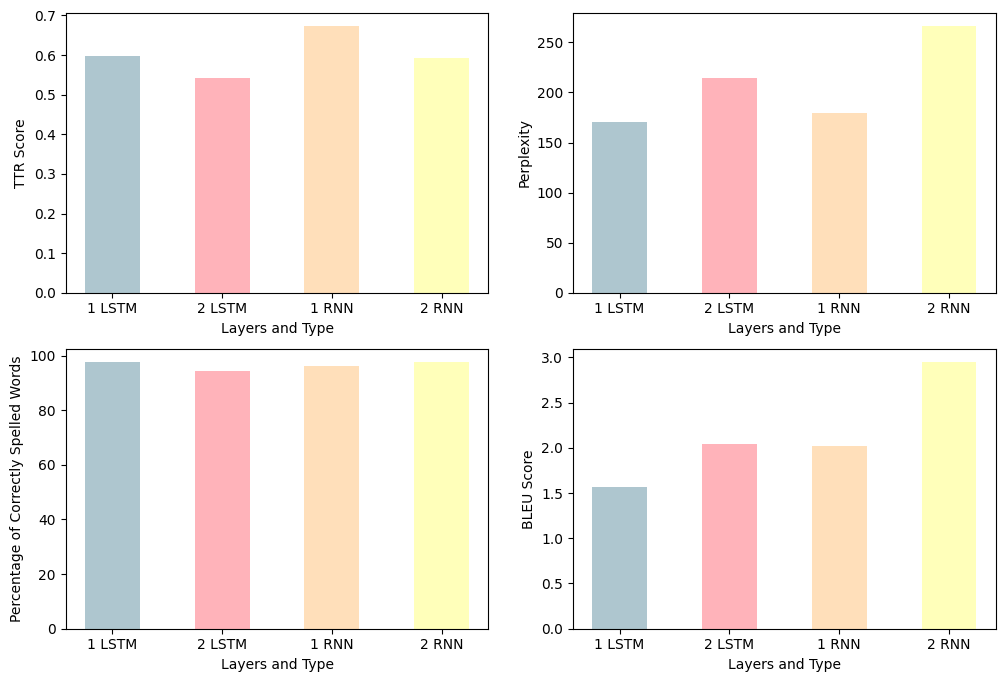

In [99]:
types = ['lstm', 'rnn']
nb_layers = [1,2]

seq_length = 100

texts = []

for l in nb_layers:
    for t in types:
        model = CharModel(n_vocab, embedding_dim=50, hidden_size=256, num_layers=l, dropout=0, norm=False, type=t).to(device)
        best_model = torch.load(f"RNNvsLSTM/{t}_layers_{l}_embedding_50_norm_False_dropout_0.pt")
        n_vocab = len(char_to_int)
        int_to_char = dict((i, c) for c, i in char_to_int.items())
        model.load_state_dict(best_model)
        model.eval()
        nucleus_text = generate_from_text(temperature=0.8, p=0.9, prompt='Alice', doPrint=False)
        # nucleus_text = generate_from_text(temperature=0.8, p=0.9, prompt=None, doPrint=False)
        texts.append(nucleus_text)
ttr_scores = []
perplexity_scores = []
text_percentage_scores = []
bleu_scores = []
for k in range(len(nb_layers)*len(types)):
    ttr_score = calculate_ttr(texts[k])
    ttr_scores.append(ttr_score)
    perplexity_score = calculate_perplexity(texts[k], gpt2_model, tokenizer, device)
    perplexity_scores.append(perplexity_score)
    text_percentage = calculate_correctly_spelled_percentage(texts[k])
    text_percentage_scores.append(text_percentage)
    bleu_score = calculate_bleu_score(reference_text, texts[k]) * 100
    bleu_scores.append(bleu_score)
    
indices = np.arange(len(nb_layers)*len(types))
f = plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.bar(indices, ttr_scores, width=0.5, color=pastel_colors)  # Use pastel colors
plt.xlabel('Layers and Type')
plt.ylabel('TTR Score')
# plt.title('TTR Score for Different Hidden Sizes')
plt.xticks(indices, ['1 LSTM', '2 LSTM', '1 RNN', '2 RNN'])  # Set the x-ticks to the specific hidden sizes

plt.subplot(2, 2, 2)
plt.bar(indices, perplexity_scores, width=0.5, color=pastel_colors)  # Use pastel colors
plt.xlabel('Layers and Type')
plt.ylabel('Perplexity')
# plt.title('Perplexity for Different Hidden Sizes')
plt.xticks(indices, ['1 LSTM', '2 LSTM', '1 RNN', '2 RNN'])  # Set the x-ticks to the specific hidden sizes

plt.subplot(2, 2, 3)
plt.bar(indices, text_percentage_scores, width=0.5, color=pastel_colors)  # Use pastel colors
plt.xlabel('Layers and Type')
plt.ylabel('Percentage of Correctly Spelled Words')
# plt.title('Percentage of Correctly Spelled Words for Different Hidden Sizes')
plt.xticks(indices, ['1 LSTM', '2 LSTM', '1 RNN', '2 RNN'])  # Set the x-ticks to the specific hidden sizes

plt.subplot(2, 2, 4)
plt.bar(indices, bleu_scores, width=0.5, color=pastel_colors)  # Use pastel colors
plt.xlabel('Layers and Type')
plt.ylabel('BLEU Score')
# plt.title('BLEU Score for Different Hidden Sizes')
plt.xticks(indices, ['1 LSTM', '2 LSTM', '1 RNN', '2 RNN'])  # Set the x-ticks to the specific hidden sizes
plt.show()


## Regularization Tuning

Done.
Done.
Done.


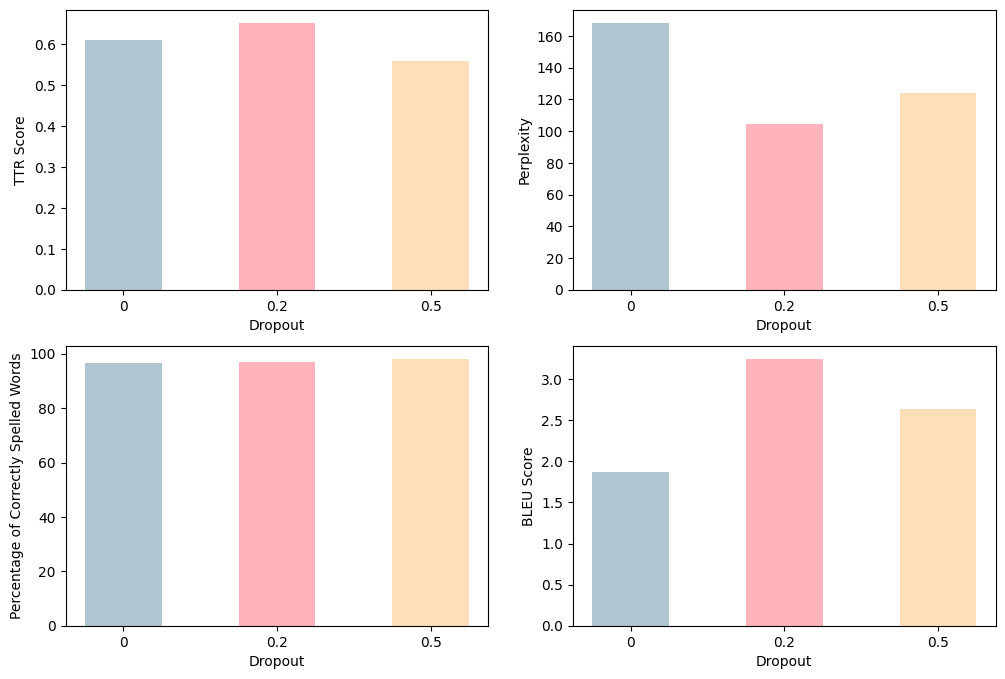

In [97]:
dropout = [0, 0.2, 0.5]

seq_length = 100

texts = []

for d in dropout:
    model = CharModel(n_vocab, embedding_dim=50, hidden_size=256, num_layers=2, dropout=d, norm=False, type='lstm').to(device)
    best_model = torch.load(f"LSTM_Dropout_LayerNorm/lstm_layers_2_dropout_{d}_norm_False.pt")
    n_vocab = len(char_to_int)
    int_to_char = dict((i, c) for c, i in char_to_int.items())
    model.load_state_dict(best_model)
    model.eval()
    nucleus_text = generate_from_text(temperature=0.8, p=0.9, prompt='Alice', doPrint=False)
    texts.append(nucleus_text)
ttr_scores = []
perplexity_scores = []
text_percentage_scores = []
bleu_scores = []
for k in range(len(dropout)):
    ttr_score = calculate_ttr(texts[k])
    ttr_scores.append(ttr_score)
    perplexity_score = calculate_perplexity(texts[k], gpt2_model, tokenizer, device)
    perplexity_scores.append(perplexity_score)
    text_percentage = calculate_correctly_spelled_percentage(texts[k])
    text_percentage_scores.append(text_percentage)
    bleu_score = calculate_bleu_score(reference_text, texts[k]) * 100
    bleu_scores.append(bleu_score)
indices = np.arange(len(dropout))

pastel_colors = ['#aec6cf', '#ffb3ba', '#ffdfba', '#ffffba']

f = plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.bar(indices, ttr_scores, width=0.5, color=pastel_colors)  # Use pastel colors
plt.xlabel('Dropout')
plt.ylabel('TTR Score')
# plt.title('TTR Score for Different Hidden Sizes')
plt.xticks(indices, dropout)  # Set the x-ticks to the specific hidden sizes

plt.subplot(2, 2, 2)
plt.bar(indices, perplexity_scores, width=0.5, color=pastel_colors)  # Use pastel colors
plt.xlabel('Dropout')
plt.ylabel('Perplexity')
# plt.title('Perplexity for Different Hidden Sizes')
plt.xticks(indices, dropout)  # Set the x-ticks to the specific hidden sizes

plt.subplot(2, 2, 3)
plt.bar(indices, text_percentage_scores, width=0.5, color=pastel_colors)  # Use pastel colors
plt.xlabel('Dropout')
plt.ylabel('Percentage of Correctly Spelled Words')
# plt.title('Percentage of Correctly Spelled Words for Different Hidden Sizes')
plt.xticks(indices, dropout)  # Set the x-ticks to the specific hidden sizes

plt.subplot(2, 2, 4)
plt.bar(indices, bleu_scores, width=0.5, color=pastel_colors)  # Use pastel colors
plt.xlabel('Dropout')
plt.ylabel('BLEU Score')
# plt.title('BLEU Score for Different Hidden Sizes')
plt.xticks(indices, dropout)  # Set the x-ticks to the specific hidden sizes

plt.show()

## Learning Rate / Batch Size

Done.
Done.
Done.
Done.


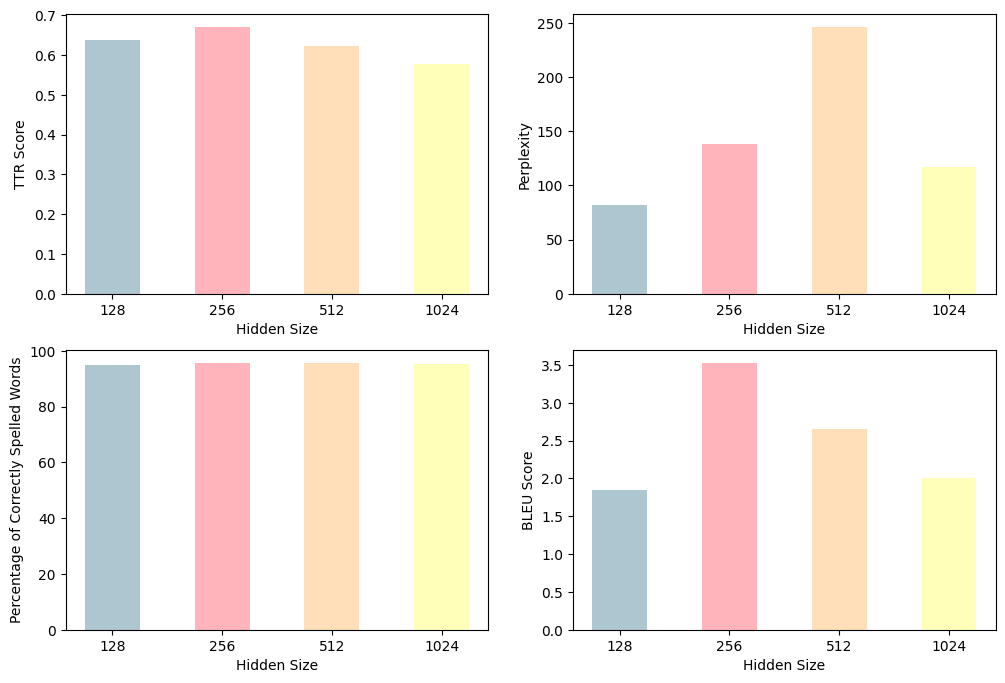

In [116]:
batch_sizes = [128, 256, 512, 1024]
seq_length = 100
texts = []

for b in batch_sizes:
    model = CharModel(n_vocab, embedding_dim=50, hidden_size=256, num_layers=2, dropout=0, norm=False, type='lstm').to(device)
    best_model = torch.load(f"LSTM_BatchSize/lstm_layers_2_hidden_256_lr_0.001_bs_{b}.pt")
    n_vocab = len(char_to_int)
    int_to_char = dict((i, c) for c, i in char_to_int.items())
    model.load_state_dict(best_model)
    model.eval()
    # nucleus_text = generate_from_text(temperature=0.8, p=0.9, prompt='A', doPrint=False)
    # nucleus_text = generate_from_text(temperature=0.8, p=0.9, prompt='Alice', doPrint=False)
    nucleus_text = generate_from_text(temperature=0.8, p=0.9, prompt=None, doPrint=False)
    texts.append(nucleus_text)

ttr_scores = []
perplexity_scores = []
text_percentage_scores = []
bleu_scores = []

for k in range(len(batch_sizes)):
    ttr_score = calculate_ttr(texts[k])
    ttr_scores.append(ttr_score)
    perplexity_score = calculate_perplexity(texts[k], gpt2_model, tokenizer, device)
    perplexity_scores.append(perplexity_score)
    text_percentage = calculate_correctly_spelled_percentage(texts[k])
    text_percentage_scores.append(text_percentage)
    bleu_score = calculate_bleu_score(reference_text, texts[k]) * 100
    bleu_scores.append(bleu_score)
    
indices = np.arange(len(batch_sizes))
pastel_colors = ['#aec6cf', '#ffb3ba', '#ffdfba', '#ffffba']
f = plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.bar(indices, ttr_scores, width=0.5, color=pastel_colors)  # Use pastel colors
plt.xlabel('Hidden Size')
plt.ylabel('TTR Score')
# plt.title('TTR Score for Different Hidden Sizes')
plt.xticks(indices, batch_sizes)  # Set the x-ticks to the specific hidden sizes

plt.subplot(2, 2, 2)
plt.bar(indices, perplexity_scores, width=0.5, color=pastel_colors)  # Use pastel colors
plt.xlabel('Hidden Size')
plt.ylabel('Perplexity')
# plt.title('Perplexity for Different Hidden Sizes')
plt.xticks(indices, batch_sizes)  # Set the x-ticks to the specific hidden sizes

plt.subplot(2, 2, 3)
plt.bar(indices, text_percentage_scores, width=0.5, color=pastel_colors)  # Use pastel colors
plt.xlabel('Hidden Size')
plt.ylabel('Percentage of Correctly Spelled Words')
# plt.title('Percentage of Correctly Spelled Words for Different Hidden Sizes')
plt.xticks(indices, batch_sizes)  # Set the x-ticks to the specific hidden sizes

plt.subplot(2, 2, 4)
plt.bar(indices, bleu_scores, width=0.5, color=pastel_colors)  # Use pastel colors
plt.xlabel('Hidden Size')
plt.ylabel('BLEU Score')
# plt.title('BLEU Score for Different Hidden Sizes')
plt.xticks(indices, batch_sizes)  # Set the x-ticks to the specific hidden sizes
plt.show()